In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [194]:
employer_data = pd.read_csv("diligence_initech.fake_initech_employer_data.csv")
financials = pd.read_excel('diligence_initech.fake_initech_income_statement.xlsx')
worker_data = pd.read_csv('diligence_initech.fake_initech_worker_data.csv')

Take rates by customer quartiles

Urgent job bonuses

# Growth Accounting

## Employer Data

In [195]:
employer_data = pd.read_csv('diligence_initech.fake_initech_employer_data.csv', parse_dates=['month'])
employer_data

,month,employer_id,market,revenue,revenue_minus_direct_costs
0,2015-01-01,9chMy7swbDZ3sqaDCqLlLUQDsMY=,sf-bay-area,0.0,0.000000
1,2015-01-01,3laXJ20VXJNgfEa0zEbBnjD3Cos=,sf-bay-area,250.0,50.000000
2,2015-01-01,nHCU9OfsFRequzQshFD1qypEJVc=,sf-bay-area,250.0,0.000000
3,2015-01-01,khcezEHqw5MZCSE5QdioEP08ZaI=,other,0.0,0.000000
4,2015-02-01,ldW+l2PmzbyDN38Q2cKswMNO6k0=,sf-bay-area,0.0,0.000000
...,...,...,...,...,...
20632,2019-06-01,KC85QAzzUqt9y9ITLcFaB6dC3Ik=,new-york-city,0.0,0.000000
20633,2019-06-01,ptpvuPAG7OhOO0EviZbixX+5An4=,los-angeles,1150.5,230.100000
20634,2019-06-01,4C67rtvvKRW/9wUZUQ0CtRXRx0Q=,new-york-city,0.0,0.000000
20635,2019-06-01,NsHaIczTmeStIgw5E0TfDe96RjE=,washington-dc,202.5,52.500008


In [196]:
df = employer_data.groupby('month').sum()
df = df.reset_index()

In [197]:
def create_CMGR_rev_graph(df, column, name):
    df.sort_values('month', inplace=True)

    def calculate_cmgr(period, index):
        if index >= period:
            return ((df[column].iloc[index] / df[column].iloc[index-period])**(1/period) - 1) * 100
        else:
            return None

    for period in [3, 6, 12, 24, 48]:
        df[f'CMGR{period}'] = [calculate_cmgr(period, i) for i in range(len(df))]


    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Month')
    ax1.set_ylabel(name, color=color)
    ax1.plot(df['month'], df[column], color=color, label=name)
    ax1.tick_params(axis='y', labelcolor=color)


    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('CMGR (%)', color=color)  


    for period in [3, 6, 12, 24, 48]:
        ax2.plot(df['month'], df[f'CMGR{period}'], linestyle='--', label=f'CMGR{period}')

    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)


    plt.title(f'Monthly {name} and {name} CMGR')

    plt.show()
    
    

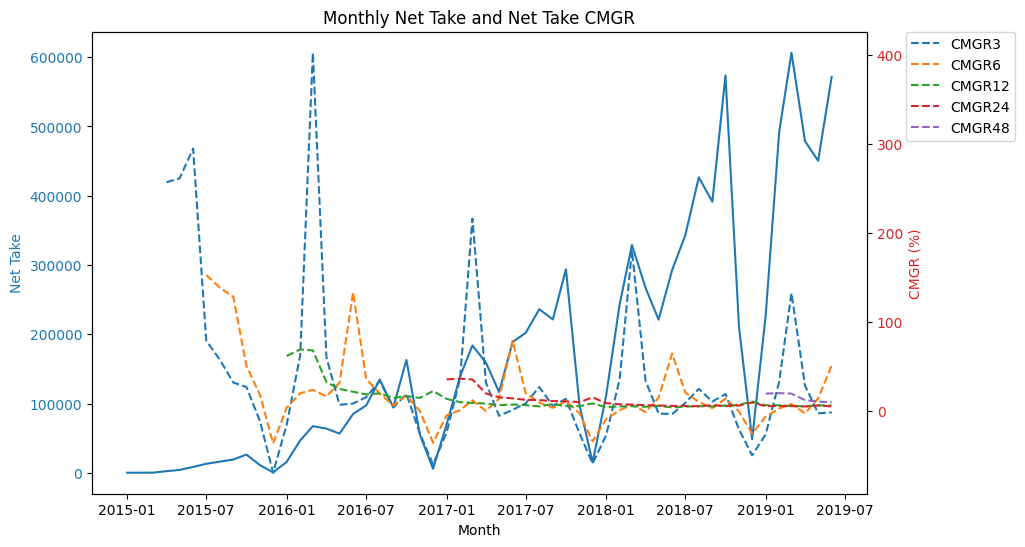

In [198]:
create_CMGR_rev_graph(df, 'revenue_minus_direct_costs', 'Net Take')

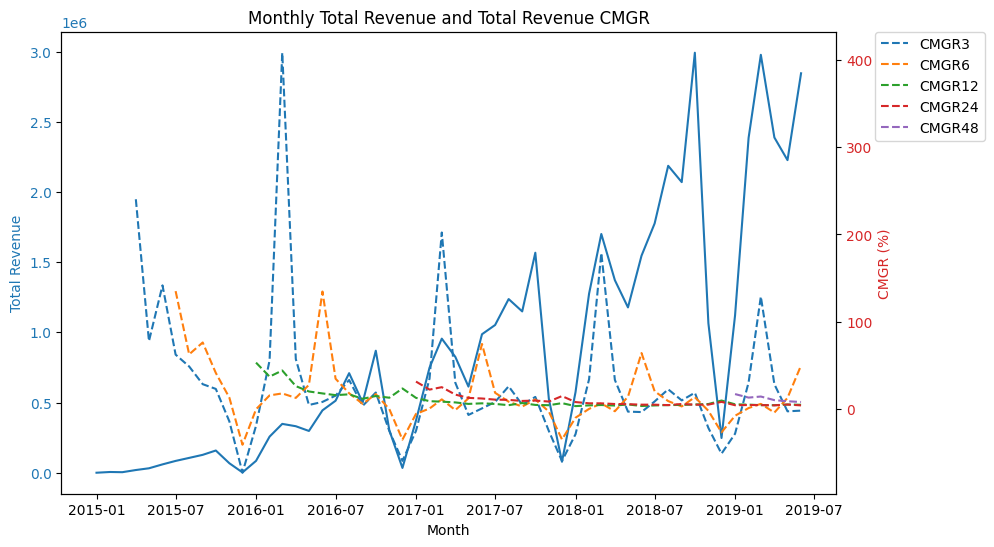

In [199]:
create_CMGR_rev_graph(df, 'revenue', 'Total Revenue')

# Regression on peaks and troughs of revenue

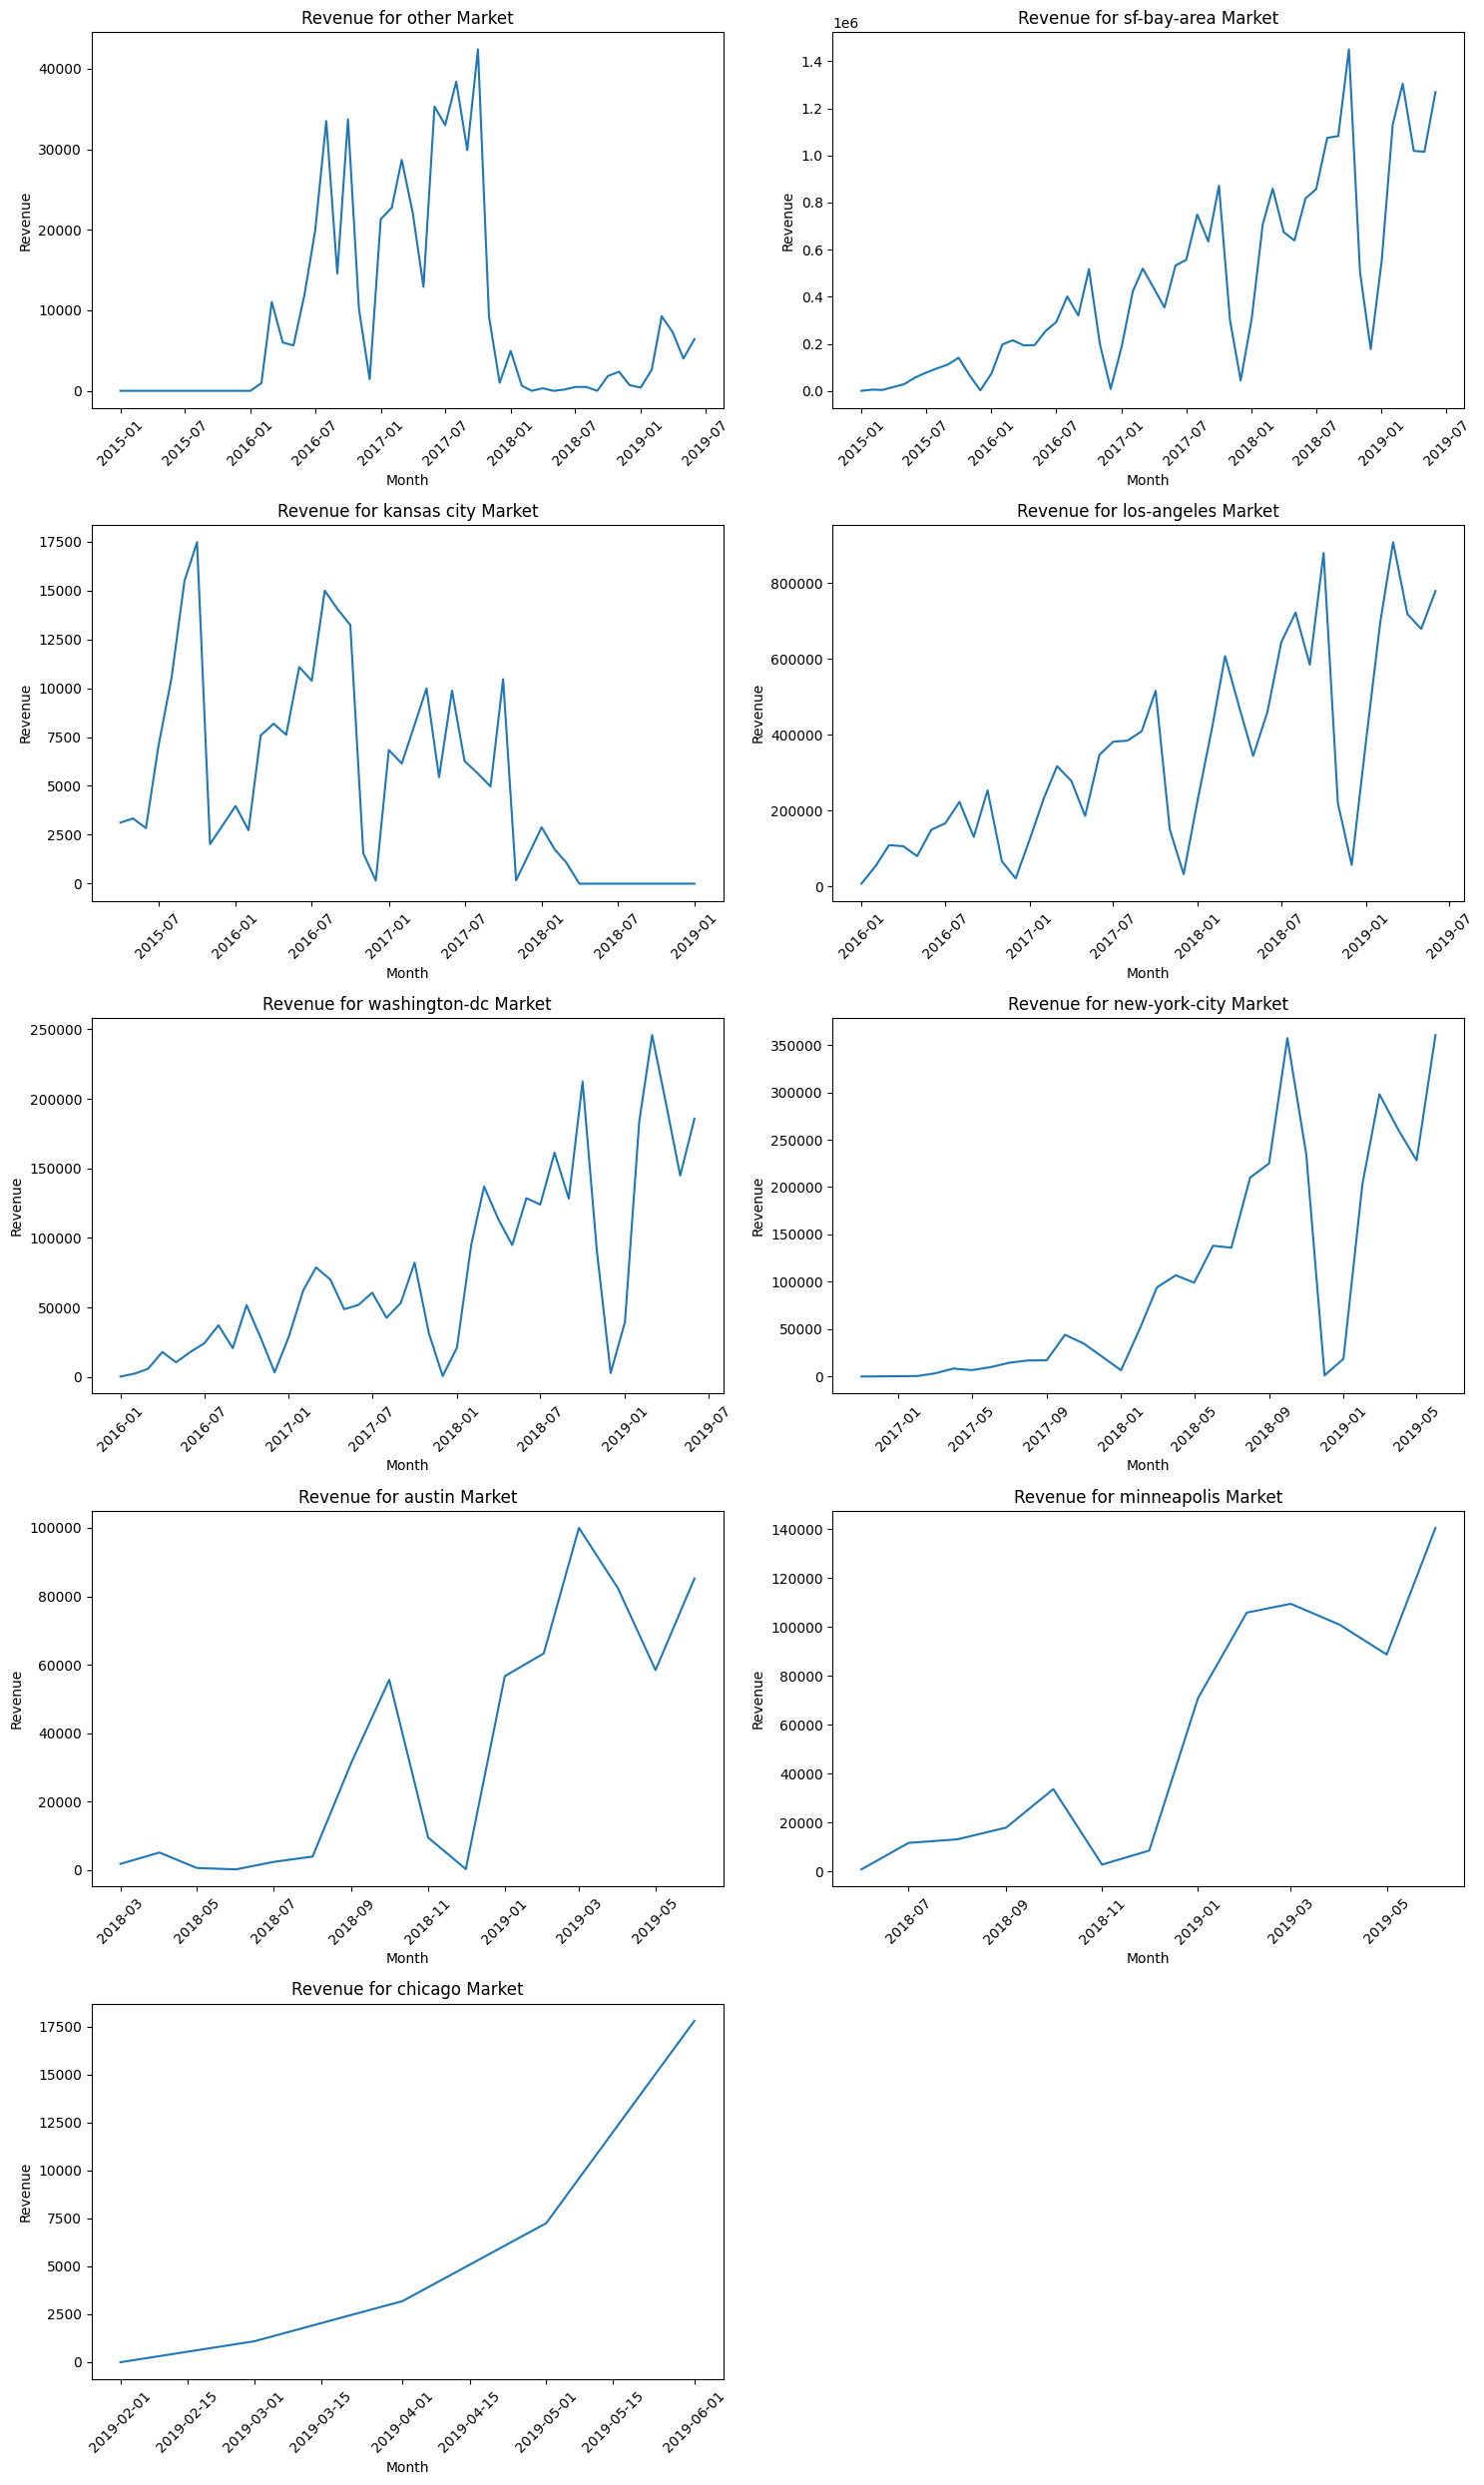

In [200]:
employer_data = pd.read_csv('diligence_initech.fake_initech_employer_data.csv', parse_dates=['month'])
worker_data = pd.read_csv('diligence_initech.fake_initech_worker_data.csv', parse_dates=['month'])

grouped_employer_data = employer_data.groupby(['month', 'market']).sum().reset_index()
grouped_employer_data.head()

unique_markets = grouped_employer_data['market'].unique()
n_cols = 2
n_rows = int(len(unique_markets) / n_cols) + (len(unique_markets) % n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
for i, market in enumerate(unique_markets):
    ax = axes[i//n_cols, i%n_cols]
    
    market_data = grouped_employer_data[grouped_employer_data['market'] == market]
    
    ax.plot(market_data['month'], market_data['revenue']) # Replace 'revenue' with your actual revenue column name
    
    ax.set_title(f'Revenue for {market} Market')
    ax.set_xlabel('Month')
    ax.set_ylabel('Revenue')
    ax.tick_params(axis='x', rotation=45)
if len(unique_markets) % n_cols != 0:
    for i in range(len(unique_markets), n_rows*n_cols):
        fig.delaxes(axes.flatten()[i])
plt.tight_layout()
plt.show()

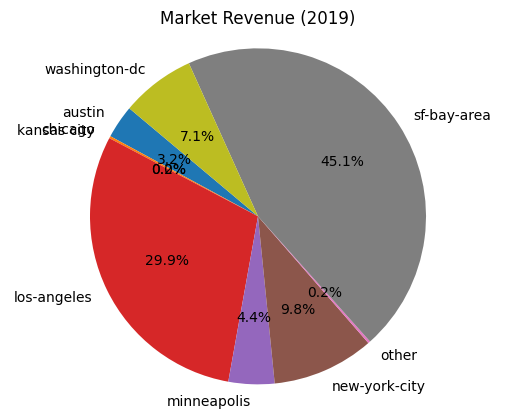

In [201]:
data_2019 = grouped_employer_data[grouped_employer_data['month'].dt.year == 2019]

# Group the data by market and sum the revenue for each market
market_revenue_2019 = data_2019.groupby('market')['revenue'].sum().reset_index()

# Create a pie chart
plt.pie(market_revenue_2019['revenue'], labels=market_revenue_2019['market'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Market Revenue (2019)')
plt.show()

In [202]:
sf_data = grouped_employer_data[grouped_employer_data['market'] == 'sf-bay-area']

In [203]:
grouped_employer_data['log_revenue'] = np.log(grouped_employer_data['revenue'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


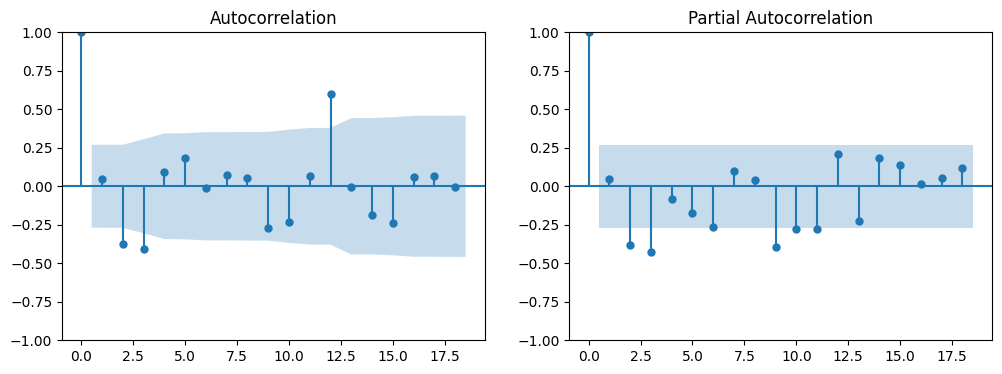

In [204]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_series = sf_data['revenue'].diff().dropna()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(diff_series, ax=ax[0])
plot_pacf(diff_series, ax=ax[1])
plt.show()

In [205]:
sf_data = sf_data.set_index('month')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregres

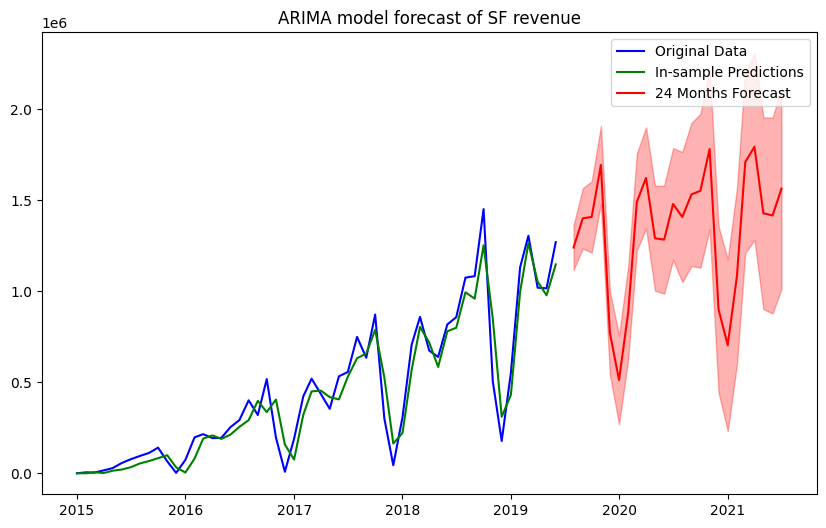

In [421]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd


result = seasonal_decompose(sf_data['revenue'], model='additive', period=12)

model = ARIMA(sf_data['revenue'], order=(12,1,0))
model_fit = model.fit()

in_sample_preds = model_fit.predict(start=1, end=len(sf_data['revenue'])-1)

in_sample_preds = pd.concat([sf_data['revenue'].iloc[:1], in_sample_preds])

forecast = model_fit.get_forecast(steps=24)
conf_int = forecast.conf_int()

forecast_index = pd.date_range(start=sf_data.index[-1], periods=25, freq='M')[1:]

forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

plt.figure(figsize=(10, 6))
plt.plot(sf_data.index, sf_data['revenue'].values, label='Original Data', color='blue')
plt.plot(sf_data.index, in_sample_preds.values, label='In-sample Predictions', color='green')
plt.plot(forecast_index, forecast_series.values, label='24 Months Forecast', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0].values, conf_int.iloc[:, 1].values, color='r', alpha=.3)
plt.title("ARIMA model forecast of SF revenue")
plt.legend()
plt.show()


# Seasonal Decomposition Regression

In [207]:
df = df.reset_index()
df = df.drop(['CMGR3', 'CMGR12', 'CMGR6', 'CMGR24', 'CMGR48'], axis=1)

In [208]:
df.columns = ['month_num', 'month', 'employer_id', 'market', 'revenue', 'revenue_minus_direct_costs']


In [209]:
from scipy.optimize import curve_fit
def exponential_func(x, a, b):
    return a*b*x
params, covariance = curve_fit(exponential_func, df['month_num'], df['revenue'])
a, b = params

In [210]:
december = df[df['month_num'] % 12 == 0]

In [211]:
params, covariance = curve_fit(exponential_func, december['month_num'], december['revenue'])
a, b = params

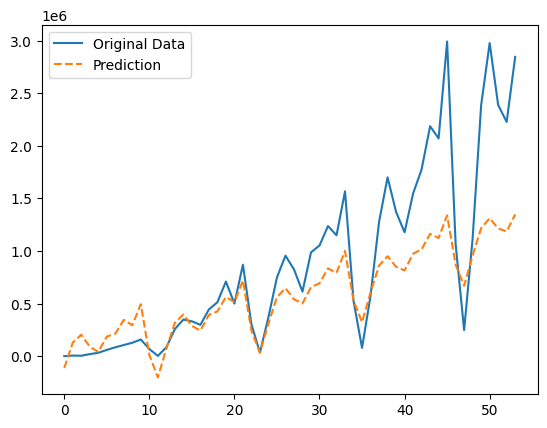

In [212]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression

trend = result.trend.dropna().values
time_trend = np.arange(len(trend))

degree = 2
X = np.column_stack([time_trend**i for i in range(degree + 1)])

coefficients = np.linalg.lstsq(X, trend, rcond=None)[0]

future_time = np.arange(len(df['revenue']) + 10)
future_trend = sum(coefficients[i] * future_time**i for i in range(degree + 1))

seasonal = result.seasonal
future_seasonal = np.tile(seasonal, len(future_time)//len(seasonal) + 1)[:len(future_time)]

prediction = future_trend + future_seasonal

plt.plot(np.arange(len(df['revenue'])), df['revenue'], label='Original Data')
plt.plot(future_time[:54], prediction[:54], label='Prediction', linestyle='dashed')
plt.legend()
plt.show()

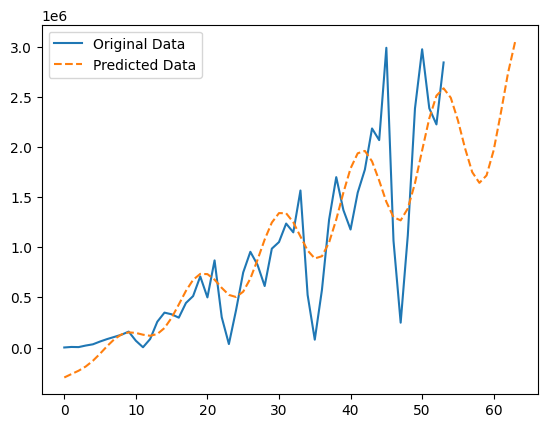

In [213]:
def func(x, a, b, c, d, e):
    return a * np.sin(b * x + c) * x + d * x + e

params, params_covariance = curve_fit(func, np.arange(len(df['revenue'])), df['revenue'], p0=[1, 0.01, 0, 0, 0])

future_time = np.arange(len(df['revenue']) + 10)
predicted_data = func(future_time, params[0], params[1], params[2], params[3], params[4])

plt.plot(df['revenue'], label='Original Data')
plt.plot(future_time, predicted_data, label='Predicted Data', linestyle='dashed')
plt.legend()
plt.show()

In [214]:
def get_metrics(data, id_name, rev_type):
    """Returns two dataframes. One is revenue metrics, and the other is user metrics"""
    
    data['month'] = pd.to_datetime(data['month'])
    first_month = data.groupby(id_name)['month'].min().reset_index()
    first_month.columns = [id_name, 'first_month']

    data = pd.merge(data, first_month, on=id_name)
    data['new'] = data['month'] == data['first_month']
    
    pivot_df = data.pivot_table(index=id_name, columns='month', values=rev_type).reset_index()
    def calculate_revenue_metrics(pivot_df, month1, month2, df):
        # Calculate total revenue for the previous and current month
        total_revenue_t1 = df[df['month'] == month1][rev_type].sum()
        total_revenue_t2 = df[df['month'] == month2][rev_type].sum()

        # Other metrics as before
        new_revenue = df[(df['month'] == month2) & (df['new'])][rev_type].sum()
        churned_revenue = pivot_df[(pivot_df[month1] > 0) & (pivot_df[month2].isnull())][month1].sum()
        resurrected_revenue = df[(df['month'] == month2) & (~df['new']) & (df['month'] != df['first_month']) & df[id_name].isin(pivot_df[pivot_df[month1].isnull() & (pivot_df[month2] > 0)][id_name])][rev_type].sum()
        expansion_revenue = df[(df['month'] == month2) & df[id_name].isin(pivot_df[(pivot_df[month1] < pivot_df[month2])][id_name])][rev_type].sum() - pivot_df[(pivot_df[month1] < pivot_df[month2])][month1].sum()
        contraction_revenue = pivot_df[(pivot_df[month1] > pivot_df[month2]) & (pivot_df[month2] > 0)][month1].sum() - df[(df['month'] == month2) & df[id_name].isin(pivot_df[(pivot_df[month1] > pivot_df[month2]) & (pivot_df[month2] > 0)][id_name])]['revenue'].sum()
        retained_revenue = df[(df['month'] == month2) & df[id_name].isin(pivot_df[(pivot_df[month1] > 0) & (pivot_df[month2] > 0)][id_name])][rev_type].sum()

        # Calculate Net_Churn and Gross_retention
        if total_revenue_t1 != 0: # Avoid division by zero
            net_churn = ((churned_revenue + contraction_revenue - resurrected_revenue - expansion_revenue) / total_revenue_t1)
            gross_retention = (retained_revenue / total_revenue_t1)
        else:
            net_churn = None
            gross_retention = None

        metrics = {
            'date': month2,
            'new_revenue': new_revenue,
            'churned_revenue': churned_revenue,
            'resurrected_revenue': resurrected_revenue,
            'expansion_revenue': expansion_revenue,
            'contraction_revenue': contraction_revenue,
            'retained_revenue': retained_revenue,
            'total_revenue': total_revenue_t2,
            'net_churn': net_churn,
            'gross_retention': gross_retention,
        }
        return metrics

    # Get the unique months from your dataframe
    unique_months = data['month'].sort_values().unique()

    # List to store the metrics dictionaries for each month
    metrics_list = []

    # Loop through pairs of months and calculate the metrics
    for i in range(len(unique_months) - 1):
        month1 = unique_months[i]
        month2 = unique_months[i + 1]

        metrics = calculate_revenue_metrics(pivot_df, month1, month2, data)
        metrics_list.append(metrics)

    # Create a DataFrame from the metrics list
    revenue_metrics_df = pd.DataFrame(metrics_list)

    
    return revenue_metrics_df

In [215]:
rev = get_metrics(employer_data, 'employer_id', 'revenue')
rev['quick_ratio'] = (rev['new_revenue'] + rev['resurrected_revenue'] + rev['expansion_revenue']) / (rev['churned_revenue'] + rev['contraction_revenue'])
rev.head()

,date,new_revenue,churned_revenue,resurrected_revenue,expansion_revenue,contraction_revenue,retained_revenue,total_revenue,net_churn,gross_retention,quick_ratio
0,2015-02-01,4187.50,0.0,0.0,1000.00,0.00,1250.00,5687.50,-2.000000,2.500000,inf
1,2015-03-01,426.00,250.0,0.0,1625.00,2250.00,3312.50,4238.50,0.153846,0.582418,0.820400
2,2015-04-01,5816.88,808.5,500.0,10500.00,375.00,7750.00,19691.88,-2.316032,1.828477,14.209447
3,2015-05-01,200.00,750.0,0.0,14064.78,375.00,30726.66,32081.66,-0.657112,1.560372,12.679804
4,2015-06-01,3905.30,0.0,387.5,27891.25,3585.91,52137.00,59889.80,-0.769687,1.625134,8.975142


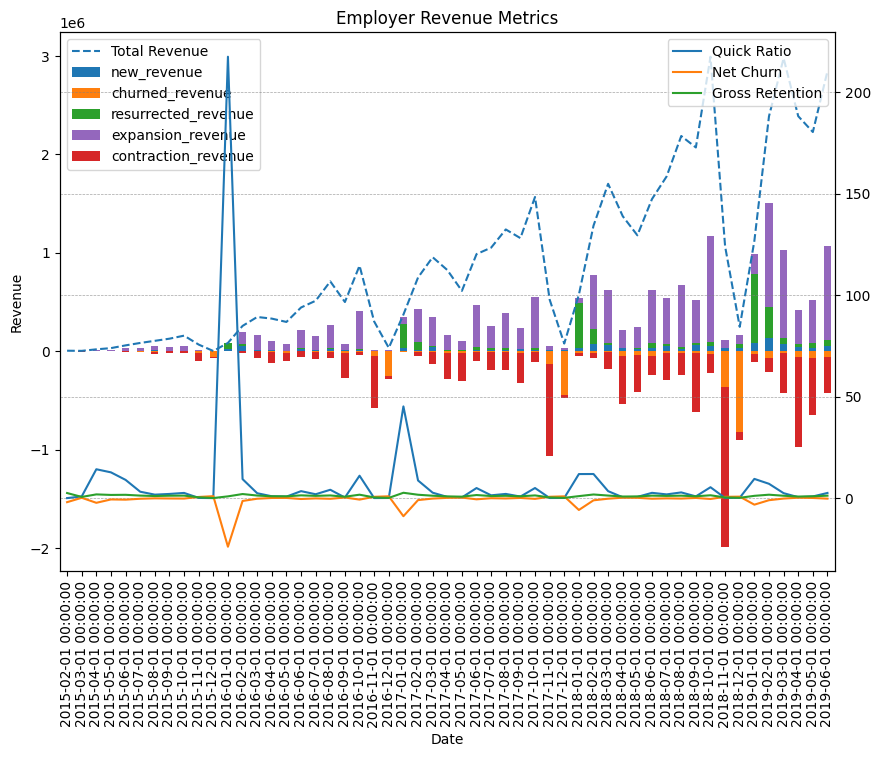

In [216]:
rev.replace([np.inf, -np.inf], 0, inplace=True)
rev['churned_revenue'] = -rev['churned_revenue']
rev['contraction_revenue'] = -rev['contraction_revenue']
rev = rev.drop(['retained_revenue'], axis=1)
colors = [
    '#1f77b4', # new_revenue
    '#ff7f0e', # churned_revenue
    '#2ca02c', # resurrected_revenue
    '#9467bd', # expansion_revenue
    '#d62728', # contraction_revenue
]
# Step 3: Create a stacked bar chart
ax = rev[['date','new_revenue', 'churned_revenue', 'resurrected_revenue','expansion_revenue', 'contraction_revenue']].plot(x='date', kind='bar', stacked=True, figsize=(10, 7), color=colors)

# Create a new y-axis for the quick ratio
ax2 = ax.twinx()
ax2.plot(rev['quick_ratio'], label="Quick Ratio")
ax2.plot(rev['net_churn'], label="Net Churn")
ax2.plot(rev['gross_retention'], label="Gross Retention")
ax.plot(rev['total_revenue'], label='Total Revenue', linestyle='--')
ax2.legend()
# Step 3: Customize the chart
plt.title('Employer Revenue Metrics')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
ax.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='y', alpha=0.7)


plt.show()

### IMPORTANT NOTE
Every year on the 12-01, there is a complete crash in revenue. Very predicatable lumps and troughs

## Worker Data

In [217]:
rev_worker = get_metrics(worker_data, 'worker_id', 'revenue')
rev_worker['quick_ratio'] = (rev_worker['new_revenue'] + rev_worker['resurrected_revenue'] + rev_worker['expansion_revenue']) / (rev_worker['churned_revenue'] + rev_worker['contraction_revenue'])


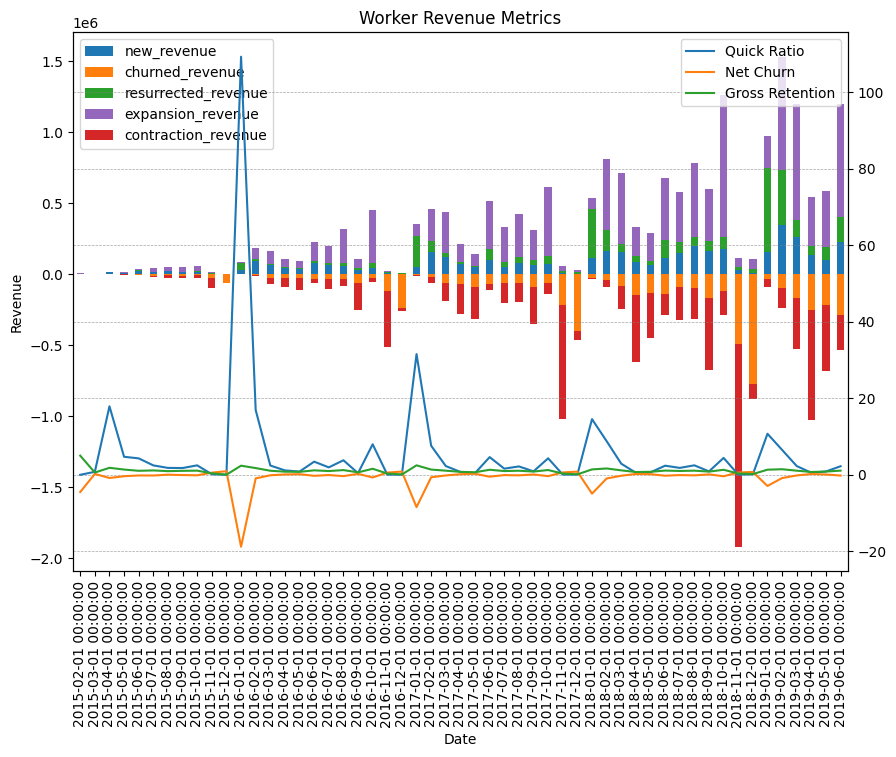

In [218]:
rev_worker.replace([np.inf, -np.inf], 0, inplace=True)
rev_worker['churned_revenue'] = -rev_worker['churned_revenue']
rev_worker['contraction_revenue'] = -rev_worker['contraction_revenue']
rev_worker = rev_worker.drop(['retained_revenue'], axis=1)
colors = [
    '#1f77b4', # new_revenue
    '#ff7f0e', # churned_revenue
    '#2ca02c', # resurrected_revenue
    '#9467bd', # expansion_revenue
    '#d62728', # contraction_revenue
]
ax = rev_worker[['date','new_revenue', 'churned_revenue', 'resurrected_revenue','expansion_revenue', 'contraction_revenue']].plot(x='date', kind='bar', stacked=True, figsize=(10, 7), color=colors)

ax2 = ax.twinx()
ax2.plot(rev_worker['quick_ratio'], label="Quick Ratio")
ax2.plot(rev_worker['net_churn'], label="Net Churn")
ax2.plot(rev_worker['gross_retention'], label="Gross Retention")
ax2.legend()


plt.title('Worker Revenue Metrics')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.grid(color='gray', linestyle='--', linewidth=0.5, axis='y', alpha=0.7)


plt.show()

## Supply and Demand dynamics of workers and employers

Lack of worker supply can be denoted by outliers in "take", meaning lower take for a specific worker

In [219]:
employer_data = pd.read_csv('diligence_initech.fake_initech_employer_data.csv', parse_dates=['month'])
worker_data = pd.read_csv('diligence_initech.fake_initech_worker_data.csv', parse_dates=['month'])
employer_count = employer_data.groupby('month').count()
worker_count = worker_data.groupby('month').count()
data = pd.DataFrame(employer_count['employer_id'])
emp_data = data.reset_index()
data2 = pd.DataFrame(worker_count['worker_id'])
wrk_data = data2.reset_index()
merged_df = pd.merge(emp_data, wrk_data, on='month')
merged_df.columns = ['month', 'employer_count', 'worker_count']
merged_df['empl_to_wrk_ratio'] = merged_df['employer_count'] / merged_df['worker_count']

In [220]:
rev_worker.columns = ['month', 'new_wrk', 'churned_wrk', 'resurrected_wrk', 'expansion_wrk', 'contraction_wrk', 'total_rev_wrk', 'net_churn_wrk', 'gross_retention_wrk', 'quick_ratio_wrk']

rev.columns = ['month', 'new_emp', 'churned_emp', 'resurrected_emp', 'expansion_emp', 'contraction_emp', 'total_rev_emp', 'net_churn_emp', 'gross_retention_emp', 'quick_ratio_emp'] 





In [221]:
merged_df = pd.merge(merged_df, rev_worker, on='month')

In [222]:
merged_df = pd.merge(merged_df, rev, on='month')

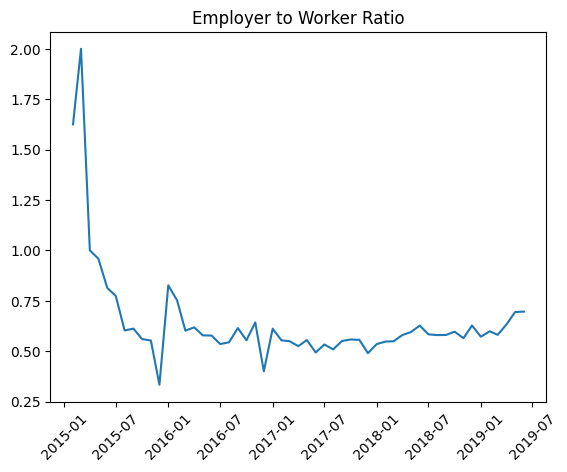

In [223]:
plt.plot(merged_df['month'], merged_df['empl_to_wrk_ratio'])
plt.title("Employer to Worker Ratio")
plt.xticks(rotation=45)
plt.show();

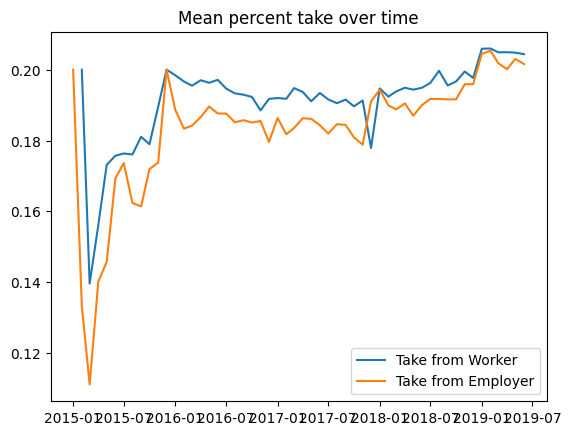

In [242]:
plt.plot(worker_data3['percent_take'], label = 'Take from Worker')
plt.plot(employer_data3['percent_take'], label = 'Take from Employer')
plt.legend()
plt.title("Mean percent take over time")
plt.show()

In [243]:
merged_df['gross_retention_wrk_t+1'] = merged_df['gross_retention_wrk'].shift(1)

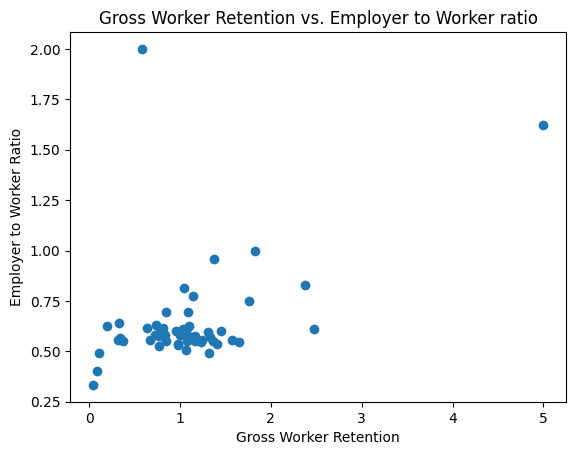

In [244]:
plt.scatter(merged_df['gross_retention_wrk'], merged_df['empl_to_wrk_ratio'])
plt.title("Gross Worker Retention vs. Employer to Worker ratio")
plt.xlabel("Gross Worker Retention")
plt.ylabel("Employer to Worker Ratio")
plt.show()

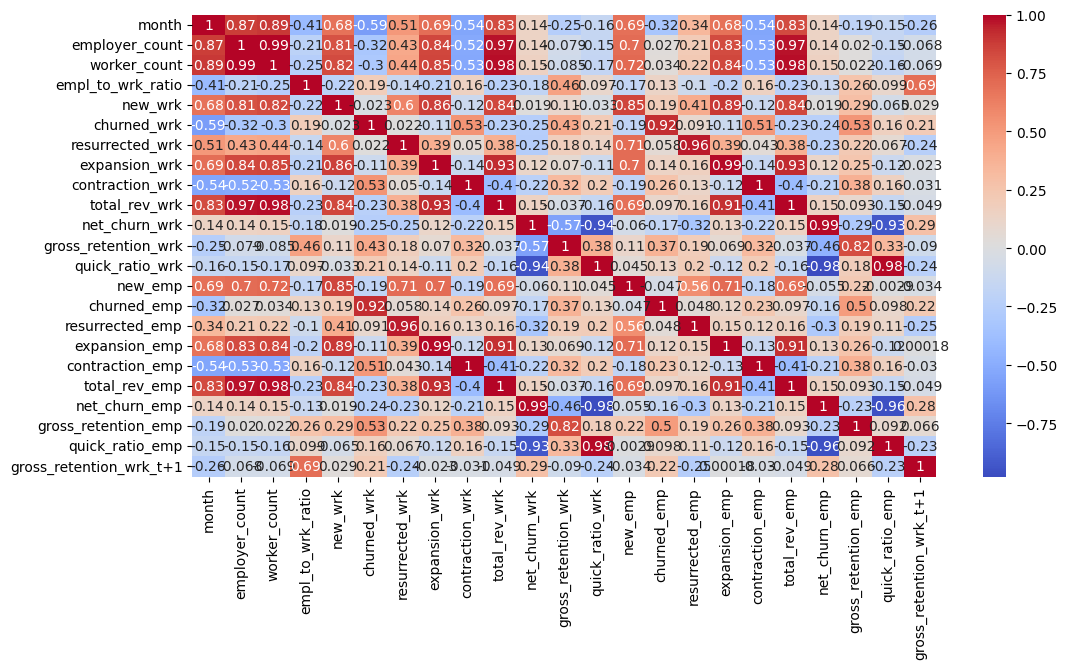

In [250]:


corr = merged_df.corr()
plt.figure(figsize=(12, 6))

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

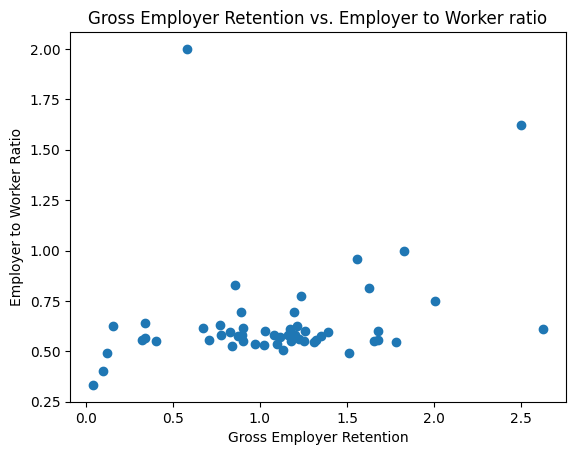

In [83]:
plt.scatter(merged_df['gross_retention_emp'], merged_df['empl_to_wrk_ratio'])
plt.title("Gross Employer Retention vs. Employer to Worker ratio")
plt.xlabel("Gross Employer Retention")
plt.ylabel("Employer to Worker Ratio")
plt.show()

# amount of money lost by non-earners by month

In [401]:
df = worker_data.sort_values('percent_take', ascending=True)

In [402]:
filtered_df = df[(df['revenue_minus_direct_costs'] < 0) & (df['revenue'] == 0.0)]

In [403]:
filtered = filtered_df.groupby('month').sum()

In [404]:
loss = df[(df['revenue_minus_direct_costs'] < 0) & (df['revenue'] > 0.0)]
to_plot = loss.groupby('month').sum()

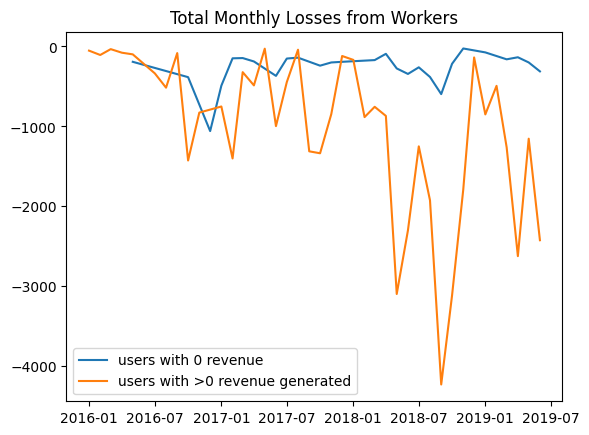

In [405]:
plt.plot(filtered['revenue_minus_direct_costs'], label = 'users with 0 revenue')
plt.plot(to_plot['revenue_minus_direct_costs'], label = 'users with >0 revenue generated')
plt.legend()
plt.title("Total Monthly Losses from Workers");

In [410]:
employer_data = pd.read_csv('diligence_initech.fake_initech_employer_data.csv', parse_dates=['month'])
total_rev = employer_data.groupby('month').sum()

In [416]:
x = pd.merge(total_rev, to_plot, on='month')


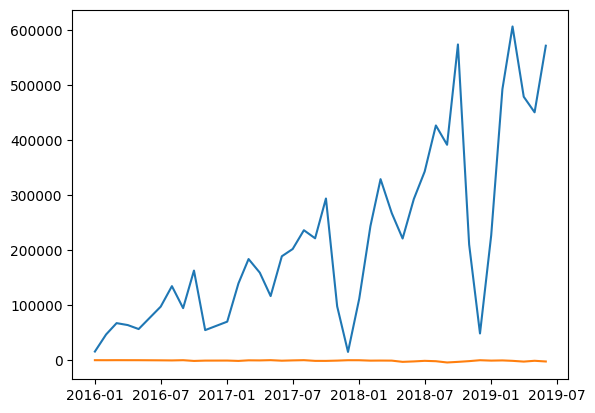

In [417]:
plt.plot(x['revenue_minus_direct_costs_x'])
plt.plot(x['revenue_minus_direct_costs_y'])

In [229]:
employer_data['percent_take'] = employer_data['revenue_minus_direct_costs'] / employer_data['revenue']
worker_data['percent_take'] = worker_data['revenue_minus_direct_costs'] / worker_data['revenue']

In [230]:
employer_data2 = employer_data[(employer_data['revenue_minus_direct_costs'] > 0) & (employer_data['revenue'] > 0.0)]
employer_data2 = employer_data2.drop(['employer_id', 'market'], axis = 1)
employer_data3 = employer_data2.groupby('month').mean()

In [231]:
worker_data2 = worker_data[(worker_data['revenue_minus_direct_costs'] > 0) & (worker_data['revenue'] > 0.0)]

In [232]:
worker_data2 = worker_data2.drop(['worker_id', 'market'], axis = 1)

In [233]:
worker_data3 = worker_data2.groupby('month').mean()

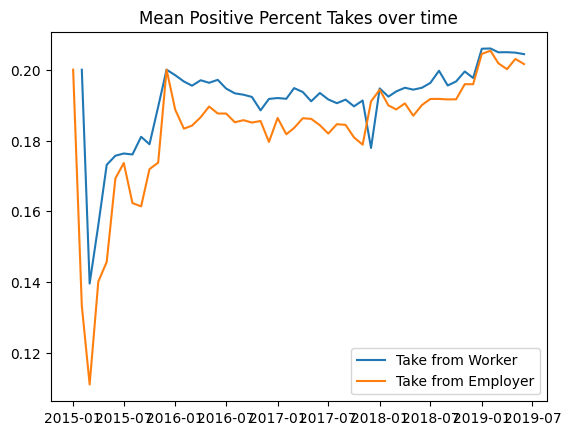

In [234]:
plt.plot(worker_data3['percent_take'], label = 'Take from Worker')
plt.plot(employer_data3['percent_take'], label = 'Take from Employer')
plt.legend()
plt.title('Mean Positive Percent Takes over time');


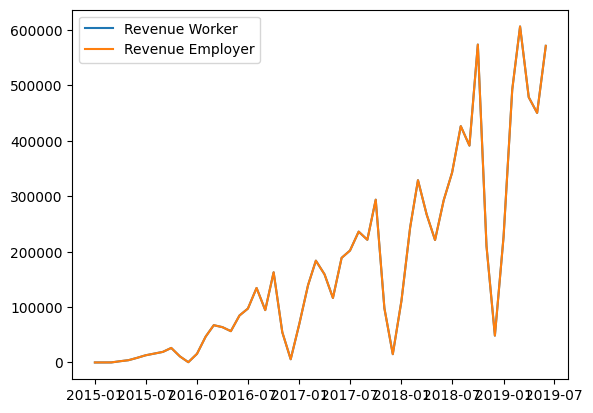

In [235]:
agg1 = worker_data.groupby('month').sum()
agg2 = employer_data.groupby('month').sum()

plt.plot(agg1['revenue_minus_direct_costs'], label = 'Revenue Worker')
plt.plot(agg2['revenue_minus_direct_costs'], label = 'Revenue Employer')
plt.legend()

Take Rate quartiles

In [236]:
import seaborn as sns

In [237]:
worker_take_wrk = worker_data[(worker_data['revenue_minus_direct_costs'] > 0) & (worker_data['revenue'] > 0.0)]
employer_take_wrk = employer_data[(employer_data['revenue_minus_direct_costs'] > 0) & (employer_data['revenue'] > 0.0)]

In [238]:
worker_take_wrk.head()

,month,worker_id,market,revenue,revenue_minus_direct_costs,percent_take
9,2015-02-01,2HmyOemaoIvMDePXy2Yj9K1Fbrw=,sf-bay-area,187.50,37.500,0.200000
14,2015-03-01,wKd4gfaZF8EDf0qsDnCixk8B/Ys=,sf-bay-area,621.00,49.200,0.079227
15,2015-03-01,2HmyOemaoIvMDePXy2Yj9K1Fbrw=,sf-bay-area,187.50,37.500,0.200000
20,2015-04-01,X10QQ7pkZ9ICaUcdAp7eyJm1vF8=,sf-bay-area,2875.00,75.000,0.026087
21,2015-04-01,uAE24X01M3Q39BNBGYQZBGtLS74=,kansas-city,735.32,110.298,0.150000


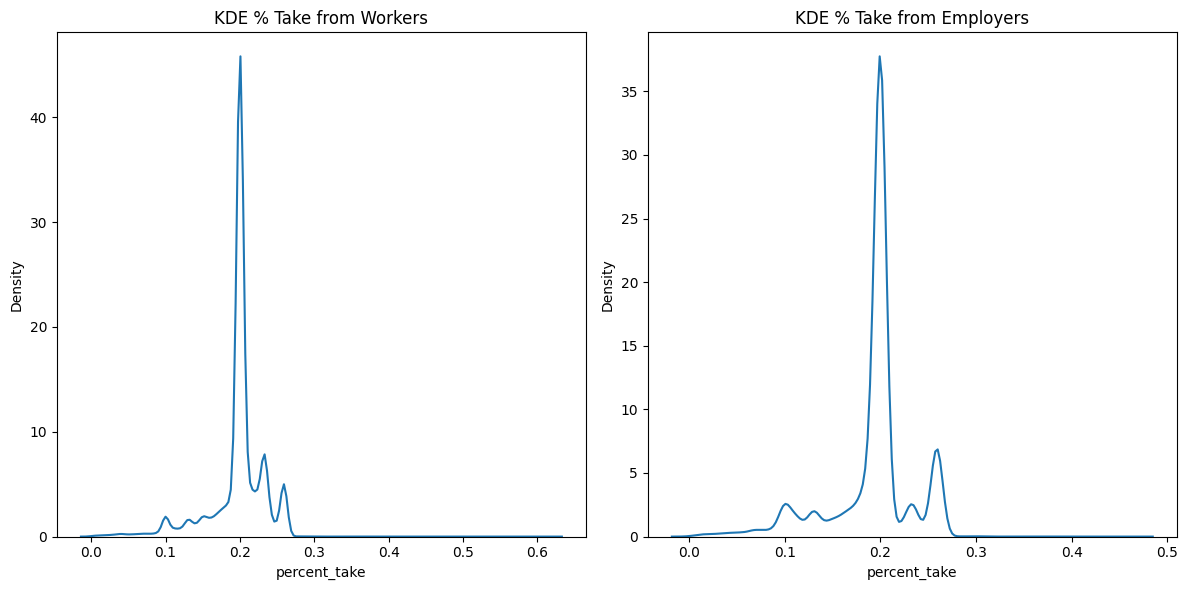

In [239]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first KDE plot on the first subplot
sns.kdeplot(worker_take_wrk['percent_take'], ax=axes[0])
axes[0].set_title('KDE % Take from Workers')

# Plot the second KDE plot on the second subplot
sns.kdeplot(employer_take_wrk['percent_take'], ax=axes[1])
axes[1].set_title('KDE % Take from Employers')

# Display the plot
plt.tight_layout()
plt.show()

In [240]:
from sklearn.mixture import GaussianMixture


In [260]:
def mixture_category(take_data, num_components, graph):
    data = np.array(take_data['percent_take'])
    data = data.reshape(-1, 1)

    gmm = GaussianMixture(n_components=num_components)
    gmm.fit(data)
    
    labels = gmm.predict(data)
    data_with_labels = np.hstack((data, labels.reshape(-1, 1)))
    
    # Map each label to its respective mean and variance
    means = {i: mean[0] for i, mean in enumerate(gmm.means_)}
    variances = {i: covariance[0, 0] for i, covariance in enumerate(gmm.covariances_)}
    
    take_data['distribution'] = data_with_labels[:, 1]
    take_data['mean'] = take_data['distribution'].map(means)
    take_data['variance'] = take_data['distribution'].map(variances)
    
    if graph: 
        x = np.linspace(min(data), max(data), 1000).reshape(-1,1)
        logprob = gmm.score_samples(x)
        pdf = np.exp(logprob)
        plt.hist(data, bins=30, density=True, alpha=0.5)
        plt.plot(x, pdf, '-k')
        plt.xlabel('Data')
        plt.ylabel('Probability')
        plt.title('GMM')
        plt.show();

    return take_data


In [313]:
df_empl = mixture_category(employer_take_wrk, 6, False)

/var/folders/t0/sbfkb15j4pqb9f4l0fqqfkkw0000gn/T/ipykernel_73229/547451116.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  take_data['distribution'] = data_with_labels[:, 1]
/var/folders/t0/sbfkb15j4pqb9f4l0fqqfkkw0000gn/T/ipykernel_73229/547451116.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  take_data['mean'] = take_data['distribution'].map(means)
/var/folders/t0/sbfkb15j4pqb9f4l0fqqfkkw0000gn/T/ipykernel_73229/547451116.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [314]:
df_empl['mean'].unique()

array([0.19996159, 0.05970852, 0.17533112, 0.10234481, 0.25920547,
       0.23313554])

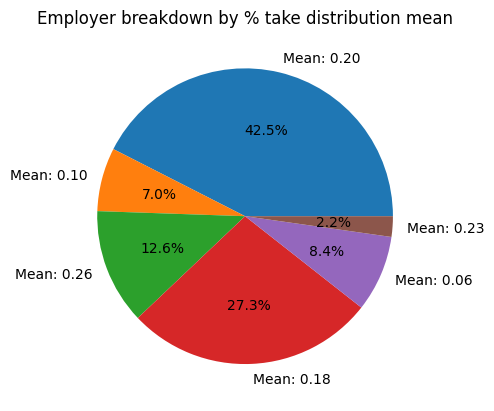

In [317]:
grouped = df_empl.groupby(['distribution', 'mean'])['employer_id'].nunique().reset_index()

# Create a pie chart
plt.figure()
plt.pie(grouped['employer_id'], labels=grouped['mean'].apply(lambda x: f'Mean: {x:.2f}'), autopct='%1.1f%%')
plt.title('Employer breakdown by % take distribution mean')
plt.show()

In [318]:
df_wrk = mixture_category(worker_take_wrk, 6, False)

/var/folders/t0/sbfkb15j4pqb9f4l0fqqfkkw0000gn/T/ipykernel_73229/547451116.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  take_data['distribution'] = data_with_labels[:, 1]
/var/folders/t0/sbfkb15j4pqb9f4l0fqqfkkw0000gn/T/ipykernel_73229/547451116.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  take_data['mean'] = take_data['distribution'].map(means)
/var/folders/t0/sbfkb15j4pqb9f4l0fqqfkkw0000gn/T/ipykernel_73229/547451116.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

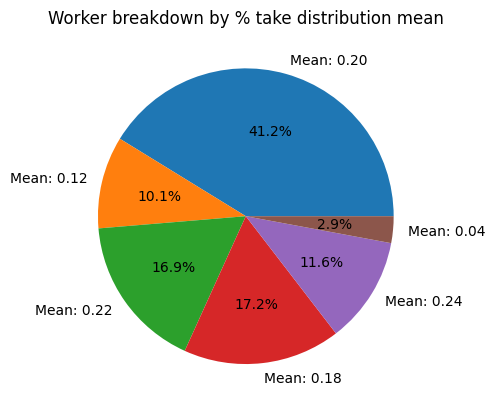

In [319]:
grouped = df_wrk.groupby(['distribution', 'mean'])['worker_id'].nunique().reset_index()

# Create a pie chart
plt.figure()
plt.pie(grouped['worker_id'], labels=grouped['mean'].apply(lambda x: f'Mean: {x:.2f}'), autopct='%1.1f%%')
plt.title('Worker breakdown by % take distribution mean')
plt.show()

In [320]:
df_wrk.head()

,month,worker_id,market,revenue,revenue_minus_direct_costs,percent_take,distribution,mean,variance
9,2015-02-01,2HmyOemaoIvMDePXy2Yj9K1Fbrw=,sf-bay-area,187.50,37.500,0.200000,0.0,0.200009,0.000001
14,2015-03-01,wKd4gfaZF8EDf0qsDnCixk8B/Ys=,sf-bay-area,621.00,49.200,0.079227,1.0,0.115293,0.000453
15,2015-03-01,2HmyOemaoIvMDePXy2Yj9K1Fbrw=,sf-bay-area,187.50,37.500,0.200000,0.0,0.200009,0.000001
20,2015-04-01,X10QQ7pkZ9ICaUcdAp7eyJm1vF8=,sf-bay-area,2875.00,75.000,0.026087,5.0,0.042870,0.000466
21,2015-04-01,uAE24X01M3Q39BNBGYQZBGtLS74=,kansas-city,735.32,110.298,0.150000,3.0,0.178687,0.000477


In [341]:
df_empl.head()

,month,employer_id,market,revenue,revenue_minus_direct_costs,percent_take,distribution,mean,variance,employee_percentage
1,2015-01-01,3laXJ20VXJNgfEa0zEbBnjD3Cos=,sf-bay-area,250.0,50.0,0.200000,0.0,0.199962,0.000001,1.0
8,2015-02-01,FXttqP7Xc1aszlvwJl0MKK+ez7U=,sf-bay-area,750.0,50.0,0.066667,4.0,0.059709,0.000760,1.0
16,2015-02-01,JfydLzcp3YymYIJqoP4EQjwsvlY=,sf-bay-area,187.5,37.5,0.200000,0.0,0.199962,0.000001,1.0
18,2015-03-01,6b8e086+uF3yjICwYmkyjStkr2Y=,sf-bay-area,750.0,50.0,0.066667,4.0,0.059709,0.000760,1.0
26,2015-03-01,9Jg3aKBW8Ay7Z5E1CzauDtzP6Ks=,sf-bay-area,246.0,49.2,0.200000,0.0,0.199962,0.000001,1.0


In [369]:
to_merge = merged_df[['month', 'empl_to_wrk_ratio']]
rev

,month,new_emp,churned_emp,resurrected_emp,expansion_emp,contraction_emp,total_rev_emp,net_churn_emp,gross_retention_emp,quick_ratio_emp
0,2015-02-01,4187.5000,-0.000,0.000,1.000000e+03,-0.000000e+00,5.687500e+03,-2.000000,2.500000,0.000000
1,2015-03-01,426.0000,-250.000,0.000,1.625000e+03,-2.250000e+03,4.238500e+03,0.153846,0.582418,0.820400
2,2015-04-01,5816.8800,-808.500,500.000,1.050000e+04,-3.750000e+02,1.969188e+04,-2.316032,1.828477,14.209447
3,2015-05-01,200.0000,-750.000,0.000,1.406478e+04,-3.750000e+02,3.208166e+04,-0.657112,1.560372,12.679804
4,2015-06-01,3905.3000,-0.000,387.500,2.789125e+04,-3.585910e+03,5.988980e+04,-0.769687,1.625134,8.975142
5,2015-07-01,5940.0000,-2935.000,1742.000,2.926033e+04,-8.800000e+03,8.457713e+04,-0.321713,1.237859,3.148047
6,2015-08-01,12411.2500,-7012.500,187.500,4.051342e+04,-2.420000e+04,1.061168e+05,-0.112187,1.028506,1.701631
7,2015-09-01,1695.0000,-597.500,720.000,4.001140e+04,-2.008600e+04,1.278597e+05,-0.188923,1.175400,2.051220
8,2015-10-01,1600.0000,-720.000,520.000,4.881509e+04,-1.922915e+04,1.586706e+05,-0.229830,1.224394,2.553246
9,2015-11-01,0.0000,-13655.000,4125.000,3.795000e+03,-8.292380e+04,6.787209e+04,0.558760,0.401757,0.082006


In [355]:
merged = pd.merge(to_merge, df_empl, on='month')

In [356]:
merged

,month,empl_to_wrk_ratio,employer_id,market,revenue,revenue_minus_direct_costs,percent_take,distribution,mean,variance,employee_percentage
0,2015-02-01,1.625000,FXttqP7Xc1aszlvwJl0MKK+ez7U=,sf-bay-area,750.0,50.000000,0.066667,4.0,0.059709,0.000760,1.0
1,2015-02-01,1.625000,JfydLzcp3YymYIJqoP4EQjwsvlY=,sf-bay-area,187.5,37.500000,0.200000,0.0,0.199962,0.000001,1.0
2,2015-03-01,2.000000,6b8e086+uF3yjICwYmkyjStkr2Y=,sf-bay-area,750.0,50.000000,0.066667,4.0,0.059709,0.000760,1.0
3,2015-03-01,2.000000,9Jg3aKBW8Ay7Z5E1CzauDtzP6Ks=,sf-bay-area,246.0,49.200000,0.200000,0.0,0.199962,0.000001,1.0
4,2015-03-01,2.000000,JfydLzcp3YymYIJqoP4EQjwsvlY=,sf-bay-area,562.5,37.500000,0.066667,4.0,0.059709,0.000760,1.0
...,...,...,...,...,...,...,...,...,...,...,...
16963,2019-06-01,0.696017,VbUrcZ9zoxm388fTggmkrNRd35U=,minneapolis,675.0,175.000000,0.259259,2.0,0.259205,0.000001,NaN
16964,2019-06-01,0.696017,T1dahQaAQkYnXdmYIkHQbdGYZfg=,austin,125.0,25.000000,0.200000,0.0,0.199962,0.000001,NaN
16965,2019-06-01,0.696017,r7QhtljH708PO731lKEXfl8rC5c=,new-york-city,270.0,70.000011,0.259259,2.0,0.259205,0.000001,NaN
16966,2019-06-01,0.696017,ptpvuPAG7OhOO0EviZbixX+5An4=,los-angeles,1150.5,230.100000,0.200000,0.0,0.199962,0.000001,NaN


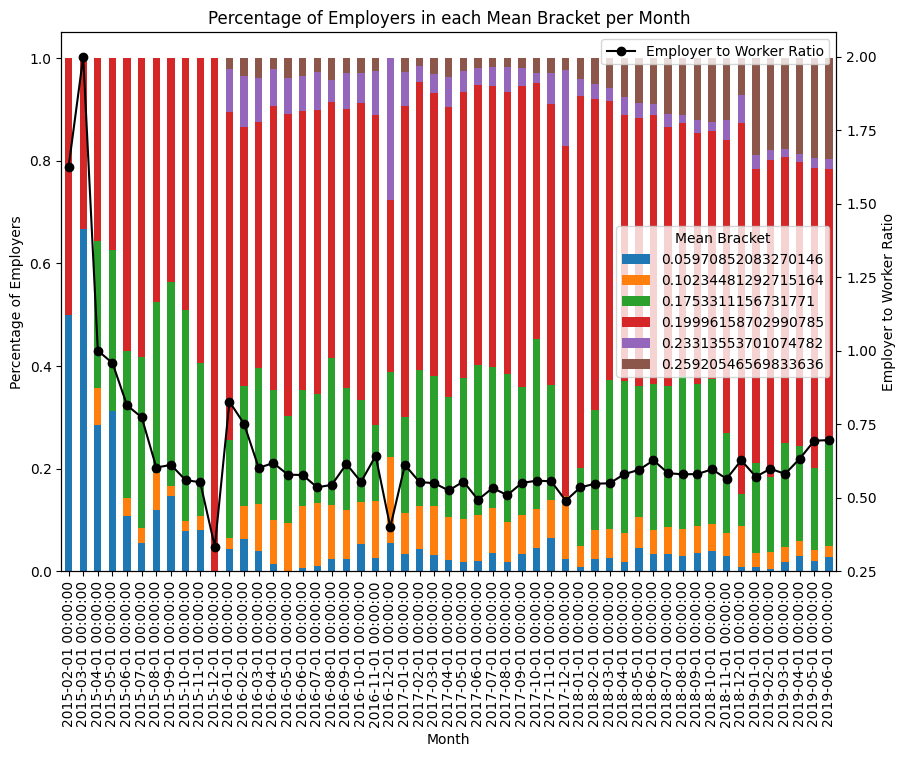

In [357]:
total_employees_per_month = merged.groupby('month')['employer_id'].nunique()

# Step 4: Calculate the percentage of employees in each mean bracket for each month
employee_percentage = merged.groupby(['month', 'mean'])['employer_id'].nunique() / total_employees_per_month
employee_percentage = employee_percentage.reset_index(name='employee_percentage')

# Step 5: Create a pivot table for plotting
pivot_df = employee_percentage.pivot_table(values='employee_percentage', index='month', columns='mean', aggfunc='sum', fill_value=0)

ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 7))
ax.set_xlabel('Month')
ax.set_ylabel('Percentage of Employers')
ax.set_title('Percentage of Employers in each Mean Bracket per Month')
ax.legend(title='Mean Bracket')

# Create a second y-axis for the Employer to Worker Ratio
ax2 = ax.twinx()
ax2.plot(merged_df.index, merged_df['empl_to_wrk_ratio'], color='black', marker='o', label='Employer to Worker Ratio')
ax2.set_ylabel('Employer to Worker Ratio')
ax2.legend(loc='upper right')

plt.show()


In [360]:
merged[merged['month'] == '2015-12-01']

,month,empl_to_wrk_ratio,employer_id,market,revenue,revenue_minus_direct_costs,percent_take,distribution,mean,variance,employee_percentage
277,2015-12-01,0.333333,aCPVb/SU8DKZwTm3QL9w0MdCrPo=,sf-bay-area,2660.0,532.0,0.2,0.0,0.199962,0.000001,1.0


In [352]:
merged = merged.set_index('month')
merged = merged.drop(['employer_id', 'market'], axis = 1)
merged.groupby('mean').mean()

,empl_to_wrk_ratio,revenue,revenue_minus_direct_costs,percent_take,distribution,variance,employee_percentage
mean,,,,,,,
0.059709,0.610487,1532.772679,91.928695,0.056225,4.0,0.000760,1.0
0.102345,0.578373,1816.404689,183.763542,0.102787,1.0,0.000037,1.0
0.175331,0.589784,4475.358175,846.768481,0.177262,3.0,0.001319,1.0
0.199962,0.593976,2099.182965,419.429248,0.199964,0.0,0.000001,1.0
0.233136,0.585113,7730.150714,1800.049273,0.233095,5.0,0.000002,1.0
0.259205,0.613693,1778.061850,460.489014,0.259202,2.0,0.000001,1.0


In [399]:
merged[merged['distribution'] == 4]['revenue'].mean()

1532.7726793032787

In [367]:
merged2 = pd.merge(to_merge, df_wrk, on='month')

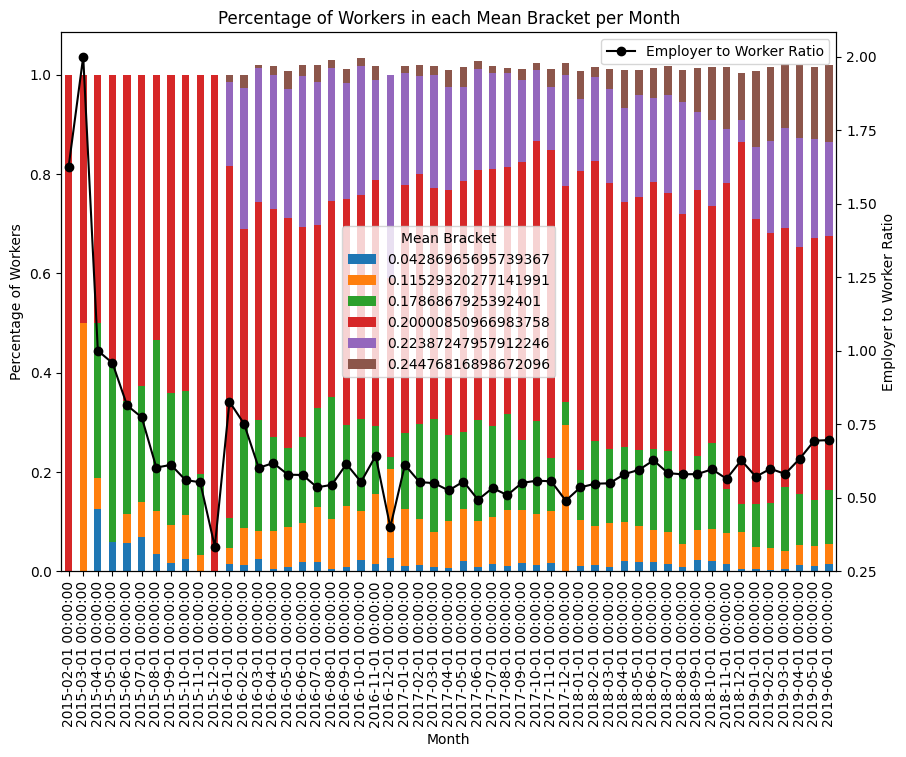

In [364]:
total_employees_per_month = merged2.groupby('month')['worker_id'].nunique()

# Step 4: Calculate the percentage of employees in each mean bracket for each month
employee_percentage = merged2.groupby(['month', 'mean'])['worker_id'].nunique() / total_employees_per_month
employee_percentage = employee_percentage.reset_index(name='employee_percentage')

# Step 5: Create a pivot table for plotting
pivot_df = employee_percentage.pivot_table(values='employee_percentage', index='month', columns='mean', aggfunc='sum', fill_value=0)

ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 7))
ax.set_xlabel('Month')
ax.set_ylabel('Percentage of Workers')
ax.set_title('Percentage of Workers in each Mean Bracket per Month')
ax.legend(title='Mean Bracket')

# Create a second y-axis for the Employer to Worker Ratio
ax2 = ax.twinx()
ax2.plot(merged_df.index, merged_df['empl_to_wrk_ratio'], color='black', marker='o', label='Employer to Worker Ratio')
ax2.set_ylabel('Employer to Worker Ratio')
ax2.legend(loc='upper right')

plt.show()

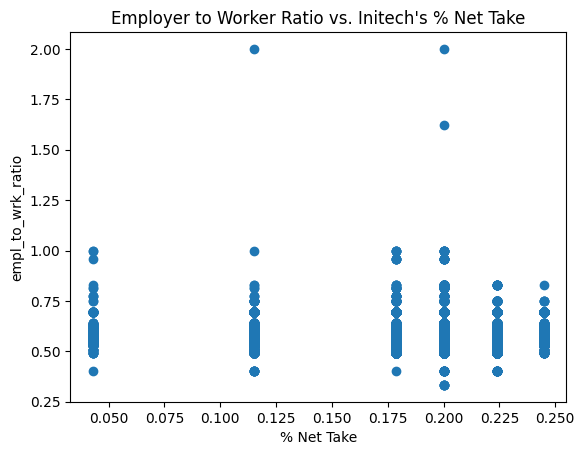

In [394]:
plt.scatter(merged2['mean'], merged2['empl_to_wrk_ratio'])
plt.ylabel("empl_to_wrk_ratio")
plt.xlabel("% Net Take")
plt.title("Employer to Worker Ratio vs. Initech's % Net Take");

In [395]:
merged2

,empl_to_wrk_ratio,revenue,revenue_minus_direct_costs,percent_take,distribution,mean,variance
month,,,,,,,
2015-02-01,1.625000,187.50,37.500000,0.200000,0.0,0.200009,0.000001
2015-03-01,2.000000,621.00,49.200000,0.079227,1.0,0.115293,0.000453
2015-03-01,2.000000,187.50,37.500000,0.200000,0.0,0.200009,0.000001
2015-04-01,1.000000,2875.00,75.000000,0.026087,5.0,0.042870,0.000466
2015-04-01,1.000000,735.32,110.298000,0.150000,3.0,0.178687,0.000477
...,...,...,...,...,...,...,...
2019-06-01,0.696017,276.16,55.232000,0.200000,0.0,0.200009,0.000001
2019-06-01,0.696017,390.00,78.000000,0.200000,0.0,0.200009,0.000001
2019-06-01,0.696017,125.00,25.000000,0.200000,0.0,0.200009,0.000001


In [368]:
merged2 = merged2.set_index('month')
merged2 = merged2.drop(['worker_id', 'market'], axis = 1)
merged2.groupby('mean').mean()

,empl_to_wrk_ratio,revenue,revenue_minus_direct_costs,percent_take,distribution,variance
mean,,,,,,
0.042870,0.595968,1297.996323,52.681328,0.040288,5.0,0.000466
0.115293,0.578257,1340.562790,153.697558,0.112655,1.0,0.000453
0.178687,0.584131,1934.159973,344.139486,0.174561,3.0,0.000477
0.200009,0.589984,1211.683913,242.373433,0.200012,0.0,0.000001
0.223872,0.587907,1780.542467,398.501911,0.223721,2.0,0.000156
0.244768,0.609860,1108.641567,284.038962,0.256591,4.0,0.000409


In [396]:
merged

,month,empl_to_wrk_ratio,employer_id,market,revenue,revenue_minus_direct_costs,percent_take,distribution,mean,variance,employee_percentage
0,2015-02-01,1.625000,FXttqP7Xc1aszlvwJl0MKK+ez7U=,sf-bay-area,750.0,50.000000,0.066667,4.0,0.059709,0.000760,1.0
1,2015-02-01,1.625000,JfydLzcp3YymYIJqoP4EQjwsvlY=,sf-bay-area,187.5,37.500000,0.200000,0.0,0.199962,0.000001,1.0
2,2015-03-01,2.000000,6b8e086+uF3yjICwYmkyjStkr2Y=,sf-bay-area,750.0,50.000000,0.066667,4.0,0.059709,0.000760,1.0
3,2015-03-01,2.000000,9Jg3aKBW8Ay7Z5E1CzauDtzP6Ks=,sf-bay-area,246.0,49.200000,0.200000,0.0,0.199962,0.000001,1.0
4,2015-03-01,2.000000,JfydLzcp3YymYIJqoP4EQjwsvlY=,sf-bay-area,562.5,37.500000,0.066667,4.0,0.059709,0.000760,1.0
...,...,...,...,...,...,...,...,...,...,...,...
16963,2019-06-01,0.696017,VbUrcZ9zoxm388fTggmkrNRd35U=,minneapolis,675.0,175.000000,0.259259,2.0,0.259205,0.000001,NaN
16964,2019-06-01,0.696017,T1dahQaAQkYnXdmYIkHQbdGYZfg=,austin,125.0,25.000000,0.200000,0.0,0.199962,0.000001,NaN
16965,2019-06-01,0.696017,r7QhtljH708PO731lKEXfl8rC5c=,new-york-city,270.0,70.000011,0.259259,2.0,0.259205,0.000001,NaN
16966,2019-06-01,0.696017,ptpvuPAG7OhOO0EviZbixX+5An4=,los-angeles,1150.5,230.100000,0.200000,0.0,0.199962,0.000001,NaN


## Income Statement

In [380]:
income = pd.read_excel('diligence_initech.fake_initech_income_statement.xlsx')

In [382]:
income = income.drop(['Category', 'Sub-Category'], axis = 1)

In [385]:
income = income.T

In [387]:
income.columns = income.iloc[0]
income = income[1:]

In [388]:
income

Line Item,Total Revenue,Worker Pay,Worker Bonuses,Employer Discounts,Payment Processing,Customer Support,DevOps,Gross Profit,Employer Marketing,Employer Sales,Worker Marketing,HR,General Management,Customer Experience,Business Operations,R&D,G&A,EBITDA,Other Net Income,Net Income
2017-06-01 00:00:00,975,799,3,0,9,27,0,137,4,33,74,62,49,0,0,91,120,-296,1,-295
2017-07-01 00:00:00,1060,855,3,0,7,29,0,166,1,41,69,59,32,0,0,91,120,-246,1,-246
2017-08-01 00:00:00,1229,1018,2,0,5,33,1,171,0,72,107,60,34,0,0,101,162,-364,-25,-389
2017-09-01 00:00:00,1140,944,9,0,23,30,0,134,16,65,94,53,44,0,0,98,125,-361,1,-360
2017-10-01 00:00:00,1568,1289,5,0,27,28,0,218,22,67,74,51,46,0,0,111,167,-320,-3,-322
2017-11-01 00:00:00,529,446,2,0,2,29,1,47,18,82,55,51,42,0,0,112,188,-500,0,-501
2017-12-01 00:00:00,37,53,1,0,1,37,1,-55,22,110,95,51,57,0,0,119,184,-693,19,-674
2018-01-01 00:00:00,547,456,1,0,8,41,3,39,34,93,76,67,50,0,0,127,129,-538,21,-518
2018-02-01 00:00:00,1356,1036,3,0,15,48,3,250,55,122,93,59,63,0,0,145,230,-515,21,-494
2018-03-01 00:00:00,1648,1372,3,0,1,47,4,222,48,169,54,50,57,0,0,169,170,-496,20,-477


In [579]:
employer_data = pd.read_csv("diligence_initech.fake_initech_employer_data.csv")
worker_data = pd.read_csv('diligence_initech.fake_initech_worker_data.csv')

# employer_data = employer_data.tail()
# worker_data = worker_data.tail(1000)

In [580]:
work_count = worker_data.set_index('month').groupby('month').nunique()

In [581]:
work_rev = worker_data.set_index('month').groupby('month').sum()

In [582]:
work_count = work_count['worker_id']
work_rev['worker_rev'] = work_rev['revenue'] - work_rev['revenue_minus_direct_costs']

In [583]:
work_rev = work_rev['worker_rev']

In [584]:
final = pd.merge(work_rev, work_count, on='month')

In [585]:
final['rev_per_worker'] = final['worker_rev']  / final['worker_id']

In [586]:
employer_count = employer_data.set_index('month').groupby('month').nunique()
employer_rev = employer_data.set_index('month').groupby('month').sum()
employer_count = employer_count['employer_id']
employer_rev['empl_rev'] = employer_rev['revenue']
employer_rev = employer_rev['empl_rev']
final2 = pd.merge(employer_rev, employer_count, on='month')
final2['rev_per_employer'] = final2['empl_rev'] / final['worker_id']

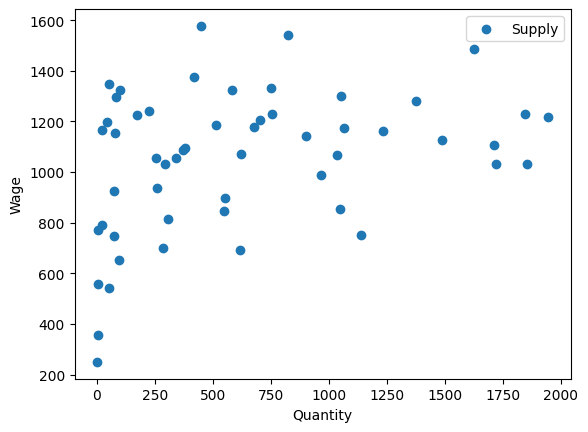

In [588]:
plt.scatter(final['worker_id'], final['rev_per_worker'], label="Supply")
# plt.scatter(final2['employer_id'], final2['rev_per_employer'], label = "Demand" )
plt.xlabel("Quantity")
plt.ylabel("Wage")
plt.legend()

In [578]:
len(final2['employer_id'])

1